In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from scipy.signal import argrelextrema
import numpy as np
from sklearn import cluster
import seaborn; seaborn.set()

In [2]:
def find_peaks(sample_path, plot=False, threshold_factor=4):
    df1 = pd.read_csv(sample_path, names=['time', 'value']).iloc[1:]
    ilocs_max = argrelextrema(df1.value.values, np.greater_equal, order=10)[0]
    if len(ilocs_max) > 0:
        if ilocs_max[0] == 0:
            ilocs_max = ilocs_max[1:]
    iloc_max_list = list(ilocs_max)
    df_median = df1['value'][ilocs_max].median()
    max_val = df1['value'][ilocs_max].max()
    threshold_factor = max_val ** (1 / threshold_factor) / 2
    filtered_iloc_max = list(filter(lambda x: df1['value'][x] > df_median * threshold_factor, iloc_max_list))
    # plot the chromatography with the peaks
    if plot:
        df1.value.plot(figsize=(20,8), alpha=.3)
        df1.iloc[filtered_iloc_max].value.plot(style='.', lw=10, color='red')
        title_name = sample_path.split('/')
        plt.title(title_name[2] + "_" + title_name[3])
    return filtered_iloc_max, df1

In [3]:
methods_dict = pd.read_csv("df_dic.csv")
methods_dict.drop(methods_dict.columns[0], axis=1, inplace=True)
drug_auto_df = pd.DataFrame()
drug_auto_df["sample"] = methods_dict["DRUG-AUTO.M"]
num_of_peaks = []
peak_locations = []
peak_values = []
sample_list = drug_auto_df['sample'].to_list()
samples = 0

In [4]:
for sample in sample_list:
    tic_front_path = sample[1:] + 'tic_front.csv'
    peaks, df = find_peaks(tic_front_path)
    num_of_peaks.append(len(peaks))
    peak_locations.append(peaks)
    peak_values.append(df['value'][peaks].values)
    samples += 1

In [5]:
drug_auto_df["num_of_peaks"] = num_of_peaks
peak1_index = []
peak1_value = []
peak2_index = []
peak2_value = []
peak3_index = []
peak3_value = []
peak4_index = []
peak4_value = []
peak5_index = []
peak5_value = []
peak6_index = []
peak6_value = []
new_columns = [(peak1_index, peak1_value), (peak2_index, peak2_value), (peak3_index, peak3_value), (peak4_index, peak4_value), (peak5_index, peak5_value), (peak6_index, peak6_value)]


for i in range(6):
    # print(new_columns[i][0])
    for j in range(samples):
        if len(peak_locations[j]) > i:
            new_columns[i][0].append(peak_locations[j][i])
        else:
            new_columns[i][0].append(-1)
        if len(peak_values[j]) > i:
            new_columns[i][1].append(peak_values[j][i])
        else:
            new_columns[i][1].append(-1)


In [6]:
for i in range(6):
    name = "peak_" + str(i+1) + "_index"
    drug_auto_df[name] = new_columns[i][0]
    name = "peak_" + str(i+1) + "_value"
    drug_auto_df[name] = new_columns[i][1]

# drug_auto_df.to_csv("drug_auto_df_times.csv")


In [7]:
one_df = pd.DataFrame()
two_df = pd.DataFrame()
three_df = pd.DataFrame()
four_df = pd.DataFrame()
five_df = pd.DataFrame()
dfs = [one_df, two_df, three_df, four_df, five_df]

for i in range(5):
    dfs[i] = drug_auto_df[drug_auto_df['num_of_peaks'] == i + 1]
    dfs[i] = dfs[i].drop([col for col in dfs[i].columns if dfs[i][col].eq(-1).any()], axis=1)
    dfs[i] = dfs[i].loc[:, dfs[i].columns != 'num_of_peaks']


# for i in range(len(dfs)):
#     name = 'drug_auto_' + str(i+1) + '_peaks.csv'
#     dfs[i].to_csv(name)
#






In [8]:
dfs[1]['difference'] = dfs[1]['peak_2_index'] - dfs[1]['peak_1_index']
# print(dfs[1]['peak_2_index'])
def scale_data(df):
  for col in df.columns:
    df[col] = absolute_maximum_scale(df[col])
  return df


def absolute_maximum_scale(series):
    return series / series.max()

cols_for_norm = dfs[1][['peak_1_value','peak_2_value']].transpose()
cols_for_norm=scale_data(cols_for_norm).transpose()

dfs[1]['peak_1_value']=cols_for_norm['peak_1_value']
dfs[1]['peak_2_value']=cols_for_norm['peak_2_value']

In [9]:
# new_df = dfs[1].loc[:, dfs[1].columns != 'sample']
# new_df = dfs[1]['difference'].values.reshape(-1, 1)
new_df = dfs[1][['peak_1_index','difference']]
clustering = cluster.KMeans(n_clusters=30)
fitted_data = clustering.fit_predict(new_df)

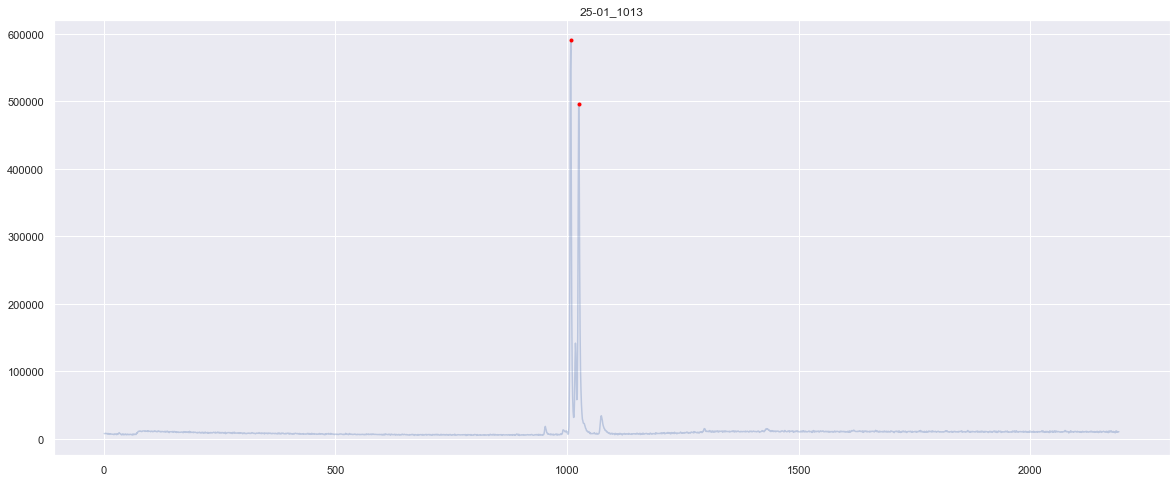

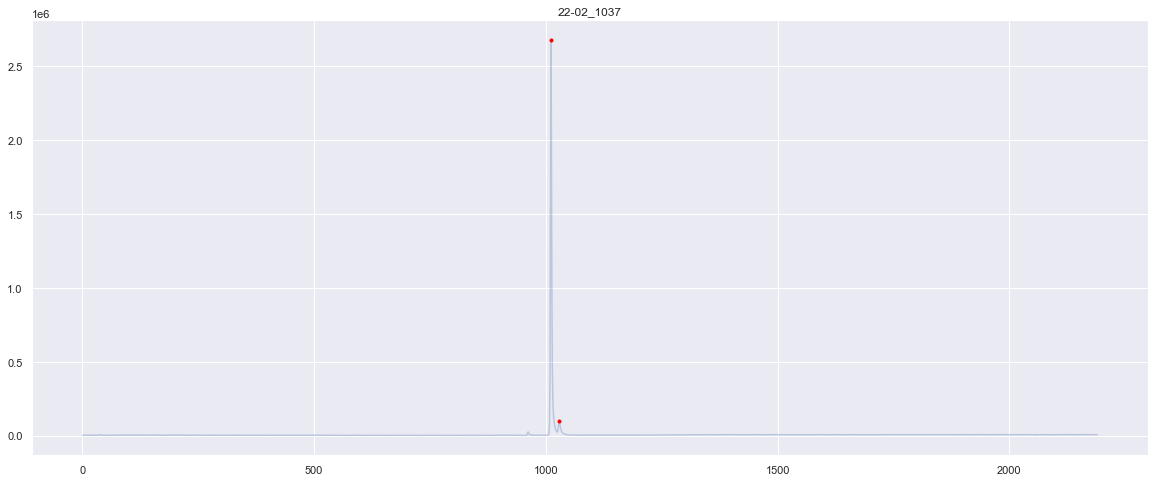

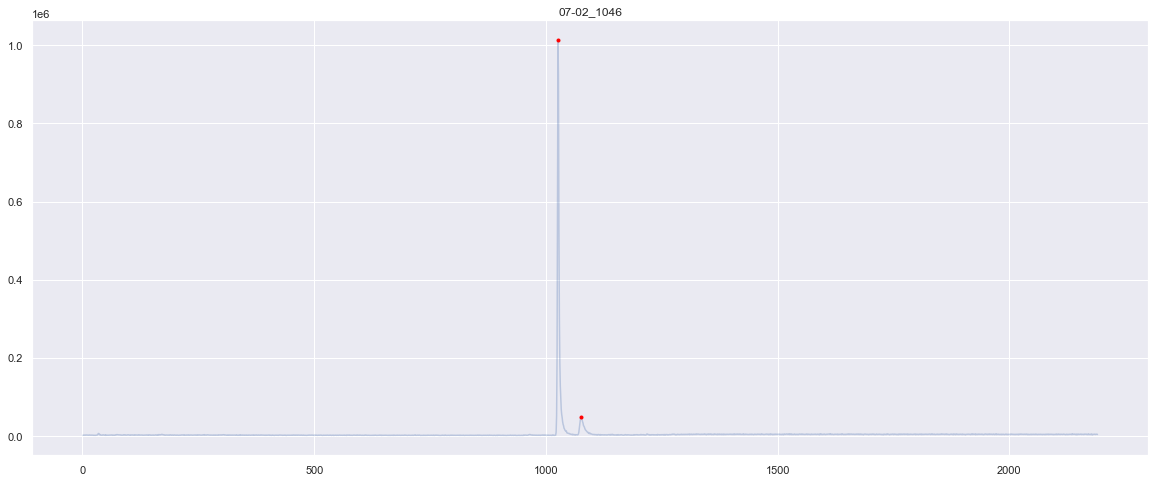

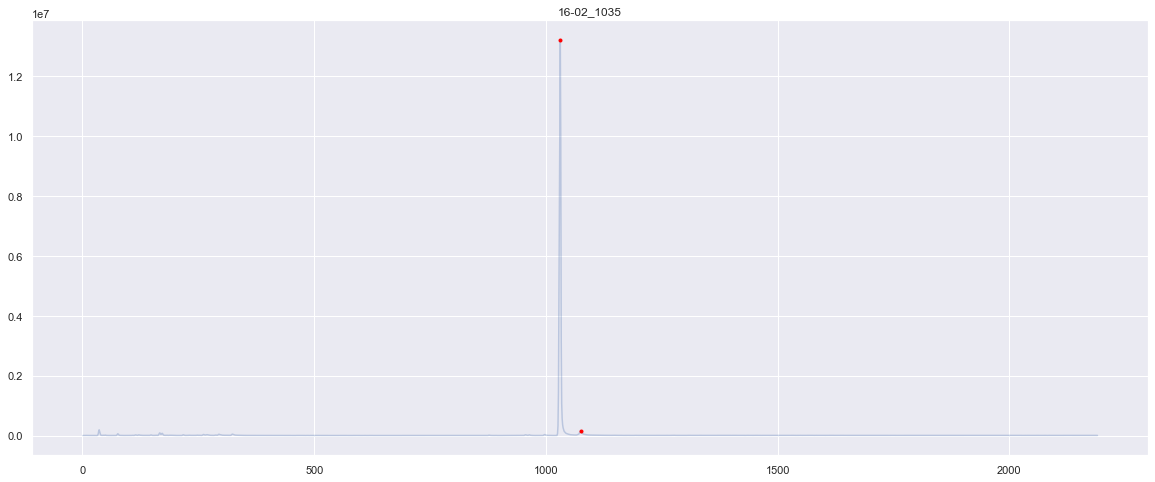

In [23]:
index = 0
for sample in dfs[1]['sample'].to_list():
    tic_front_path = sample[1:] + 'tic_front.csv'
    if fitted_data[index] == 24:
        if index < 550:
            find_peaks(tic_front_path, True)
            plt.show()
    index += 1